In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [14]:
#organize the data into tensor dataset
data = torch.tensor(iris.drop('species',axis=1).values).float()
labels = torch.tensor(iris['species'].map({'setosa':0,'versicolor':1,'virginica':2})).long()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## **Split the data into training and test datasets**

In [40]:
testsize = 0.2
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=testsize, random_state=42)

In [41]:
## Convert the data into PyTorch datsets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [42]:
## Convert the data into Dataloader objects
def make_loaders(batchsize):
  train_loader = DataLoader(train_data, shuffle=True, batch_size=batchsize)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=len(test_data.tensors[0]))

  return train_loader, test_loader

## **Create the model and train**

In [68]:
# a function that creates the ANN model

def createANewModel(learning_rate):

  # model architecture
  model = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

  return model,lossfun,optimizer

In [81]:
# train the model

def trainTheModel(batchsize, numepochs=500, lr=0.001):
  model, lossfun, optimizer = createANewModel(learning_rate=lr)
  train_loader, test_loader = make_loaders(batchsize)

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []

    for X, y in train_loader:
      # forward pass
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      preds = torch.argmax(yHat,axis=1)
      batchAcc.append((preds == y).float().mean().item()*100)
      batchLoss.append( loss.item() )
      # end of batch loop...

    # Average training accuracy and losses
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    #evaluate the model once for each epoch
    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    model.eval()

    with torch.no_grad():
      preds = torch.argmax( model(X),axis=1 )
      testAcc.append( 100*torch.mean((preds == y).float()).item() )

  # end of epoch loop

  # function output
  return trainAcc,testAcc,losses


## **Test the model**

In [82]:
## Run the model for batch sized of 2, 4, 8, 16, etc.
batchsizes = np.linspace(2,50,6)
batch_hist = {}
for batchsize in batchsizes:
  trainAcc,testAcc,losses = trainTheModel(int(batchsize),numepochs=500, lr=0.001)
  batch_hist[batchsize] = {'trainAcc': trainAcc, 'testAcc': testAcc, 'losses': losses}

## **Visualize the Results**

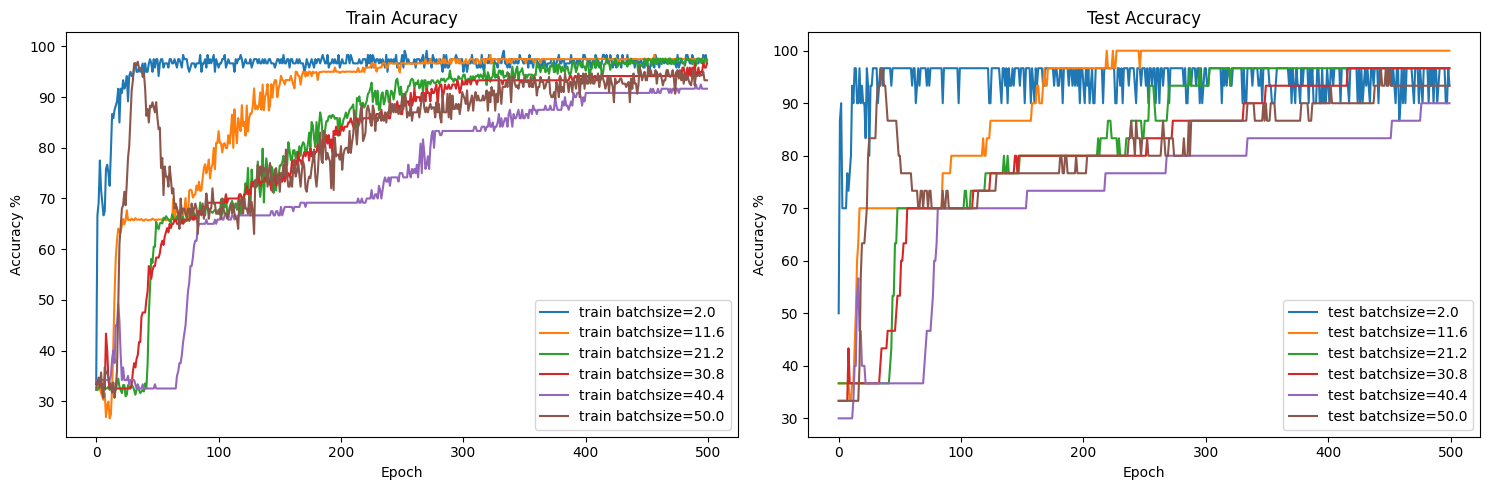

In [83]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))

batchsizes_values = [bs for bs in batchsizes]

for i, bs in enumerate(batchsizes):
  bs_val = batchsizes_values[i]
  ax[0].plot(batch_hist[bs]['trainAcc'],label=f'train batchsize={np.round(bs_val,2)}')
  ax[1].plot(batch_hist[bs]['testAcc'],label=f'test batchsize={np.round(bs_val,2)}')

ax[0].set_title('Train Acuracy')
ax[1].set_title('Test Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy %')
ax[1].set_ylabel('Accuracy %')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show();